Epoch 0: Loss = 2.2814e+03
Epoch 20: Loss = 6.7776e+02
Epoch 40: Loss = 6.2189e+02
Epoch 60: Loss = 6.2043e+02
Epoch 80: Loss = 6.1957e+02
Epoch 100: Loss = 6.1893e+02
Epoch 120: Loss = 6.1846e+02
Epoch 140: Loss = 6.1807e+02
Epoch 160: Loss = 6.1771e+02
Epoch 180: Loss = 6.1733e+02
Epoch 200: Loss = 6.1690e+02
Epoch 220: Loss = 6.1662e+02
Epoch 240: Loss = 6.1639e+02
Epoch 260: Loss = 6.1620e+02
Epoch 280: Loss = 6.1602e+02
Epoch 300: Loss = 6.1586e+02
Epoch 320: Loss = 6.1570e+02
Epoch 340: Loss = 6.1555e+02
Epoch 360: Loss = 6.1542e+02
Epoch 380: Loss = 6.1529e+02
Epoch 400: Loss = 6.1516e+02
Epoch 420: Loss = 6.1505e+02
Epoch 440: Loss = 6.1494e+02
Epoch 460: Loss = 6.1484e+02
Epoch 480: Loss = 6.1474e+02
Epoch 500: Loss = 6.1465e+02
Epoch 520: Loss = 6.1456e+02
Epoch 540: Loss = 6.1448e+02
Epoch 560: Loss = 6.1440e+02
Epoch 580: Loss = 6.1433e+02
Epoch 600: Loss = 6.1427e+02
Epoch 620: Loss = 6.1420e+02
Epoch 640: Loss = 6.1414e+02
Epoch 660: Loss = 6.1408e+02
Epoch 680: Loss = 6.

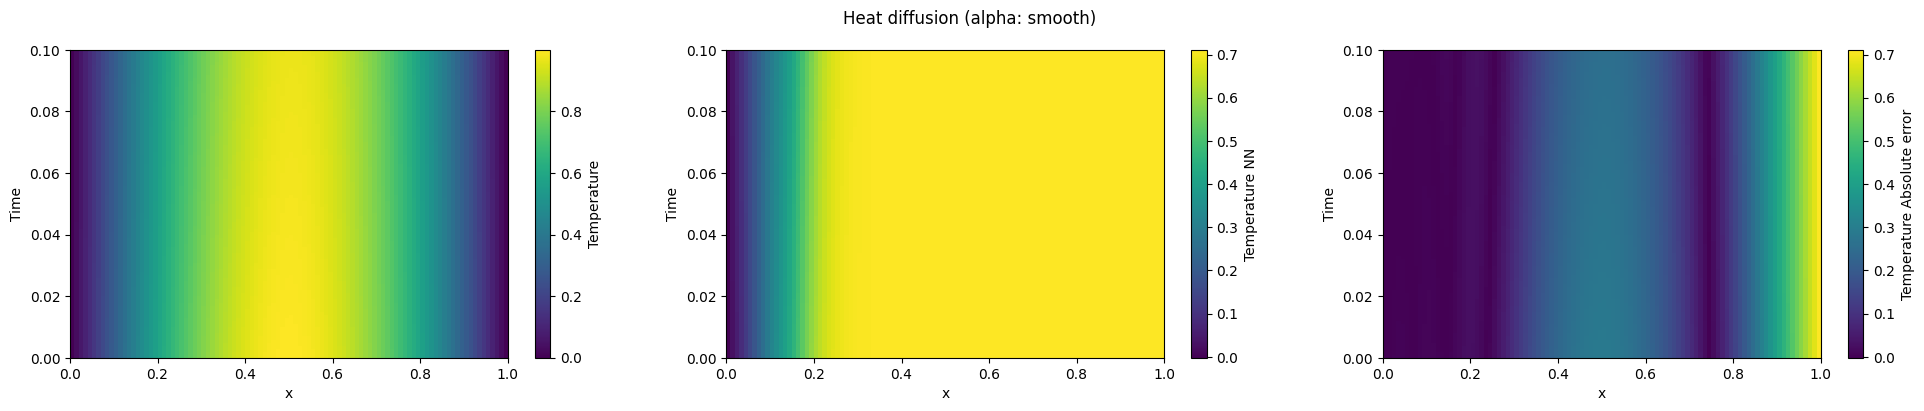

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..", "")))

from src.data_generator.heat_equations import HeatEquationDataset
from src.train.train import train
from src.figures.figures import plot_sample
from src.models.basic import alpha_network, u_network


# --- Main Execution ---
if __name__ == "__main__":

    # Create Dataset
    dataset = HeatEquationDataset(n_samples=2, nx=100, nt=100)

    # Define PINNS
    alpha_net = alpha_network()
    u_net = u_network()

    # training
    u_net.train()
    alpha_net.train()

    train(
        dataset=dataset,
        u_net=u_net,
        alpha_net=alpha_net
    )

    # plot
    u_net.eval()
    alpha_net.eval()
    sample = dataset[0]
    u_xt = u_net(xt=sample["xt"])
    plot_sample(sample, u_xt)
